<a href="https://colab.research.google.com/github/ENRICOROBLESDELRIO/data_boot_camp_final_project/blob/enrico_branch/Random_Forest_Model_50%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Random Forest Model**

## **Import dependencies and database**

In [82]:
# Libraries and dependencies

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import math
from sklearn.metrics import accuracy_score
from google.colab import files
from google.colab import drive
from google.colab import files
import psycopg2

# Libraries for Random Forest Model

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
import re

In [2]:
# Google Cloud SQL connexion:
# Code taken from: https://stackoverflow.com/questions/53180140/how-to-access-cloud-sql-from-google-colab
!gcloud auth login
!gcloud config set project endeavor-intelligence-unit
# !gcloud sql instances describe finalprojectdb

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=hKMnrSSLQ8eMpa6omL0qJg5f6gx4he&prompt=consent&access_type=offline&code_challenge=T3MP_SKnr6nv_K9gJjD4bukZyciXE0j2xN6LT6mvKfg&code_challenge_method=S256

Enter verification code: 4/1AX4XfWiYhXOyGaDe80cEhEORt6m3j0uhAV2g_XyhbrFKg-P8tGEdssTpgHE

You are now logged in as [enrico.robles@endeavor.org.mx].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID
Updated property [core/project].


In [3]:
# download and initialize the psql proxy
!wget https://dl.google.com/cloudsql/cloud_sql_proxy.linux.amd64 -O cloud_sql_proxy
!chmod +x cloud_sql_proxy

# "connectionName" is from the previous block
!nohup ./cloud_sql_proxy -instances="endeavor-intelligence-unit:northamerica-northeast2:finalprojectdb"=tcp:5432 &
!sleep 30s

--2021-11-22 03:18:03--  https://dl.google.com/cloudsql/cloud_sql_proxy.linux.amd64
Resolving dl.google.com (dl.google.com)... 74.125.195.93, 74.125.195.136, 74.125.195.91, ...
Connecting to dl.google.com (dl.google.com)|74.125.195.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16638816 (16M) [application/octet-stream]
Saving to: ‘cloud_sql_proxy’

cloud_sql_proxy     100%[===================>]  15.87M  --.-KB/s    in 0.07s   

2021-11-22 03:18:03 (234 MB/s) - ‘cloud_sql_proxy’ saved [16638816/16638816]

nohup: appending output to 'nohup.out'


In [4]:
# Connection to protect access and users to the database using a drive file: 
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Connection to the file with user and access to the database:
# Each user should use its own personal path to get access to the database and switch it below in open() function. 

with open('/content/drive/MyDrive/Personal/Data_Analytics_Boot_Camp/Final_project/Second_Deliverable/key_config.txt', "r") as file:
    FileasList = file.readlines()
    username = FileasList[0]
    password = FileasList[1]

    new_line = []
    # Loop through the file
    for i in FileasList:
        # Get rid of any new lines ("enter")
        i = i.replace("\n", "")
        # Add the cleaned data to the new_line list
        new_line.append(i)
    # Set the username to be the first object
    username = new_line[0]
    # Set the password to be the second object
    password = new_line[1]
    # Set the host to be the third object
    host = new_line[2]
    # Set the port to be the four object
    port = new_line[3]
    # Set the database to be the five object
    database = new_line[4]

In [6]:
# Connexion throught psycopg2 Google Cloud SQL data base

conn = psycopg2.connect(
    host=host, port=port, database=database,
    user=username, password=password)

In [7]:
# Query to connect with SQL data base
SQL_Query = pd.read_sql_query('''select * FROM "companies" ''', conn)
companies_df = pd.DataFrame(SQL_Query)

In [8]:
# Data base of entrepreneurs and their companies
companies_df.head(5)

,id_company,foundation_year,category,first_r_year,first_r_amount,last_funding_year,amount_last_funding,month_since_last_funding,number_employees,increase_employees,number_investors,current_status,rounds_funding_factor,soonicorn,more50_employees,more100_employees,dp_year,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_year,dp_last_round_amount,dp_years_operating,max_manager_exp,max_clevel_exp,max_engineering_exp,max_sales_exp,max_finance_exp,max_human_capital_exp,max_consulting_exp,max_founder_exp,max_number_of_startups,max_gender,max_foreing_studies,max_foreing_work_experience,max_foreing_founder,max_dp_years_of_experience,max_dp_years_of_experience_as_entreprenuer,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer,mean_manager_exp,mean_clevel_exp,mean_engineering_exp,mean_sales_exp,mean_finance_exp,mean_human_capital_exp,mean_consulting_exp,mean_founder_exp,mean_number_of_startups,mean_gender,mean_foreing_studies,mean_foreing_work_experience,mean_foreing_founder,mean_dp_years_of_experience,mean_dp_years_of_experience_as_entreprenuer
0,3.0,2017.0,0.0,2017.0,1400000.0,2017.0,1400000.0,48.0,33.0,8.0,3.0,1.0,4.0,0.0,0.0,0.0,2017.0,1.0,1400000.0,1400000.0,2017.0,1400000.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,0.0,0.0,12.0,8.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,2.0,1.0,0.0,0.0,22.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,11.0,7.0
1,7.0,2018.0,0.0,2018.0,10500.0,2018.0,10500.0,36.0,10.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,2018.0,1.0,10500.0,10500.0,2018.0,10500.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,10.0,9.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,10.0,9.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,10.0,9.0
2,10.0,2015.0,0.0,2015.0,200000.0,2015.0,200000.0,72.0,11.0,14.0,1.0,1.0,6.0,0.0,0.0,0.0,2015.0,1.0,200000.0,200000.0,2015.0,200000.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,12.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,12.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,12.0,2.0
3,23.0,2013.0,0.0,2013.0,150000.0,2021.0,40000000.0,0.0,1001.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,2021.0,5.0,54800000.0,40000000.0,2021.0,40000000.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,11.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,11.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,11.0,4.0
4,51.0,2018.0,0.0,2018.0,20000.0,2018.0,20000.0,36.0,10.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,2018.0,1.0,20000.0,20000.0,2018.0,20000.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,5.0,0.0


In [9]:
# Drop the null columns where all values are null
companies_df = companies_df.dropna(axis='columns', how='all')

# Encoding labels
le = LabelEncoder()
db_companies_Encode = companies_df.copy()

# Get the name of the columns
columnsName = db_companies_Encode.columns.tolist()
r = re.compile("^mean")
columnsName = [column for column in columnsName if not r.match(column)]

# convert variables to numerical
for column in columnsName:
  db_companies_Encode[column] = pd.to_numeric(db_companies_Encode[column], errors='coerce').fillna(0).astype(np.int64)

In [10]:
# Copy the dataframe to new one, for create the models
db_companies_Encode_Model = db_companies_Encode.copy()
db_companies_Encode_Model.head()

,id_company,foundation_year,category,first_r_year,first_r_amount,last_funding_year,amount_last_funding,month_since_last_funding,number_employees,increase_employees,number_investors,current_status,rounds_funding_factor,soonicorn,more50_employees,more100_employees,dp_year,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_year,dp_last_round_amount,dp_years_operating,max_manager_exp,max_clevel_exp,max_engineering_exp,max_sales_exp,max_finance_exp,max_human_capital_exp,max_consulting_exp,max_founder_exp,max_number_of_startups,max_gender,max_foreing_studies,max_foreing_work_experience,max_foreing_founder,max_dp_years_of_experience,max_dp_years_of_experience_as_entreprenuer,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer,mean_manager_exp,mean_clevel_exp,mean_engineering_exp,mean_sales_exp,mean_finance_exp,mean_human_capital_exp,mean_consulting_exp,mean_founder_exp,mean_number_of_startups,mean_gender,mean_foreing_studies,mean_foreing_work_experience,mean_foreing_founder,mean_dp_years_of_experience,mean_dp_years_of_experience_as_entreprenuer
0,3,2017,0,2017,1400000,2017,1400000,48,33,8,3,1,4,0,0,0,2017,1,1400000,1400000,2017,1400000,0,1,1,0,0,0,0,0,1,3,1,1,0,0,12,8,1,1,0,0,0,0,0,2,4,2,1,0,0,22,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,11.0,7.0
1,7,2018,0,2018,10500,2018,10500,36,10,0,2,0,3,0,0,0,2018,1,10500,10500,2018,10500,0,1,1,0,0,0,0,0,1,4,1,0,0,0,10,9,1,1,0,0,0,0,0,1,4,1,0,0,0,10,9,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,10.0,9.0
2,10,2015,0,2015,200000,2015,200000,72,11,14,1,1,6,0,0,0,2015,1,200000,200000,2015,200000,0,1,1,0,0,0,0,0,1,1,1,0,0,0,12,2,1,1,0,0,0,0,0,1,1,1,0,0,0,12,2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,12.0,2.0
3,23,2013,0,2013,150000,2021,40000000,0,1001,0,0,1,0,1,1,1,2021,5,54800000,40000000,2021,40000000,8,0,1,0,0,0,0,0,1,2,1,0,0,0,11,4,0,1,0,0,0,0,0,1,2,1,0,0,0,11,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,11.0,4.0
4,51,2018,0,2018,20000,2018,20000,36,10,0,1,0,3,0,0,0,2018,1,20000,20000,2018,20000,0,0,1,1,0,0,0,0,0,1,1,1,0,0,5,0,0,1,1,0,0,0,0,0,1,1,1,0,0,5,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,5.0,0.0


In [11]:
# Create de list for drop columns from Models
columnsName = db_companies_Encode_Model.columns.tolist()
r = re.compile("^mean|^max")
columnsName = [column for column in columnsName if r.match(column)]
columnsName.extend(["last_funding_year","amount_last_funding","month_since_last_funding","number_employees","increase_employees","number_investors"])

for column in columnsName:
  db_companies_Encode_Model = db_companies_Encode_Model.drop(column, axis='columns', inplace=False)
  
db_companies_Encode_Model.head()

,id_company,foundation_year,category,first_r_year,first_r_amount,current_status,rounds_funding_factor,soonicorn,more50_employees,more100_employees,dp_year,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_year,dp_last_round_amount,dp_years_operating,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer
0,3,2017,0,2017,1400000,1,4,0,0,0,2017,1,1400000,1400000,2017,1400000,0,1,1,0,0,0,0,0,2,4,2,1,0,0,22,15
1,7,2018,0,2018,10500,0,3,0,0,0,2018,1,10500,10500,2018,10500,0,1,1,0,0,0,0,0,1,4,1,0,0,0,10,9
2,10,2015,0,2015,200000,1,6,0,0,0,2015,1,200000,200000,2015,200000,0,1,1,0,0,0,0,0,1,1,1,0,0,0,12,2
3,23,2013,0,2013,150000,1,0,1,1,1,2021,5,54800000,40000000,2021,40000000,8,0,1,0,0,0,0,0,1,2,1,0,0,0,11,4
4,51,2018,0,2018,20000,0,3,0,0,0,2018,1,20000,20000,2018,20000,0,0,1,1,0,0,0,0,0,1,1,1,0,0,5,0


In [12]:
db_companies_Encode_Model.dtypes

id_company                                    int64
foundation_year                               int64
category                                      int64
first_r_year                                  int64
first_r_amount                                int64
current_status                                int64
rounds_funding_factor                         int64
soonicorn                                     int64
more50_employees                              int64
more100_employees                             int64
dp_year                                       int64
dp_rounds_count                               int64
dp_rounds_amount_sum                          int64
dp_rounds_amount_max                          int64
dp_last_round_year                            int64
dp_last_round_amount                          int64
dp_years_operating                            int64
sum_manager_exp                               int64
sum_clevel_exp                                int64
sum_engineer

In [13]:
# Generate our categorical variable lists
db_companies_cat = ["foundation_year","category","first_r_year","dp_year","current_status","dp_last_round_year"] 
db_companies_cat

['foundation_year',
 'category',
 'first_r_year',
 'dp_year',
 'current_status',
 'dp_last_round_year']

In [14]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(db_companies_Encode_Model[db_companies_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(db_companies_cat)

# Merge one-hot encoded features and drop the originals
db_companies_Encode_Model = db_companies_Encode_Model.merge(encode_df,left_index=True, right_index=True)
db_companies_Encode_Model = db_companies_Encode_Model.drop(db_companies_cat,1)

# Create de list for drop columns from Models
columnsName = db_companies_Encode_Model.columns.tolist()
columnsName.remove('rounds_funding_factor')

# convert variables to numerical
for column in columnsName:
  db_companies_Encode_Model[column] = pd.to_numeric(db_companies_Encode_Model[column], errors='coerce').fillna(0).astype(np.int64)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [15]:
db_companies_Encode_Model.dtypes

id_company                 int64
first_r_amount             int64
rounds_funding_factor      int64
soonicorn                  int64
more50_employees           int64
                           ...  
dp_last_round_year_2017    int64
dp_last_round_year_2018    int64
dp_last_round_year_2019    int64
dp_last_round_year_2020    int64
dp_last_round_year_2021    int64
Length: 91, dtype: object

In [16]:
db_companies_Encode_Model.drop("id_company", axis='columns', inplace=True)
db_companies_Encode_Model.head()

,first_r_amount,rounds_funding_factor,soonicorn,more50_employees,more100_employees,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_amount,dp_years_operating,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer,foundation_year_2000,foundation_year_2004,foundation_year_2006,foundation_year_2008,foundation_year_2009,foundation_year_2010,foundation_year_2011,foundation_year_2012,foundation_year_2013,foundation_year_2014,foundation_year_2015,foundation_year_2016,foundation_year_2017,foundation_year_2018,foundation_year_2019,...,first_r_year_2012,first_r_year_2013,first_r_year_2014,first_r_year_2015,first_r_year_2016,first_r_year_2017,first_r_year_2018,first_r_year_2019,first_r_year_2020,first_r_year_2021,dp_year_0,dp_year_2000,dp_year_2008,dp_year_2011,dp_year_2012,dp_year_2013,dp_year_2014,dp_year_2015,dp_year_2016,dp_year_2017,dp_year_2018,dp_year_2019,dp_year_2020,dp_year_2021,current_status_0,current_status_1,dp_last_round_year_0,dp_last_round_year_2000,dp_last_round_year_2008,dp_last_round_year_2011,dp_last_round_year_2012,dp_last_round_year_2013,dp_last_round_year_2014,dp_last_round_year_2015,dp_last_round_year_2016,dp_last_round_year_2017,dp_last_round_year_2018,dp_last_round_year_2019,dp_last_round_year_2020,dp_last_round_year_2021
0,1400000,4,0,0,0,1,1400000,1400000,1400000,0,1,1,0,0,0,0,0,2,4,2,1,0,0,22,15,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,10500,3,0,0,0,1,10500,10500,10500,0,1,1,0,0,0,0,0,1,4,1,0,0,0,10,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,200000,6,0,0,0,1,200000,200000,200000,0,1,1,0,0,0,0,0,1,1,1,0,0,0,12,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,150000,0,1,1,1,5,54800000,40000000,40000000,8,0,1,0,0,0,0,0,1,2,1,0,0,0,11,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,20000,3,0,0,0,1,20000,20000,20000,0,0,1,1,0,0,0,0,0,1,1,1,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


# **Random Forest**

*   Unbalanced model



In [17]:
# 1. Define features set
X = db_companies_Encode_Model.copy()
X = X.drop(["more100_employees","soonicorn","more50_employees"], axis=1)
X.head()

,first_r_amount,rounds_funding_factor,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_amount,dp_years_operating,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer,foundation_year_2000,foundation_year_2004,foundation_year_2006,foundation_year_2008,foundation_year_2009,foundation_year_2010,foundation_year_2011,foundation_year_2012,foundation_year_2013,foundation_year_2014,foundation_year_2015,foundation_year_2016,foundation_year_2017,foundation_year_2018,foundation_year_2019,foundation_year_2020,foundation_year_2021,category_0,...,first_r_year_2012,first_r_year_2013,first_r_year_2014,first_r_year_2015,first_r_year_2016,first_r_year_2017,first_r_year_2018,first_r_year_2019,first_r_year_2020,first_r_year_2021,dp_year_0,dp_year_2000,dp_year_2008,dp_year_2011,dp_year_2012,dp_year_2013,dp_year_2014,dp_year_2015,dp_year_2016,dp_year_2017,dp_year_2018,dp_year_2019,dp_year_2020,dp_year_2021,current_status_0,current_status_1,dp_last_round_year_0,dp_last_round_year_2000,dp_last_round_year_2008,dp_last_round_year_2011,dp_last_round_year_2012,dp_last_round_year_2013,dp_last_round_year_2014,dp_last_round_year_2015,dp_last_round_year_2016,dp_last_round_year_2017,dp_last_round_year_2018,dp_last_round_year_2019,dp_last_round_year_2020,dp_last_round_year_2021
0,1400000,4,1,1400000,1400000,1400000,0,1,1,0,0,0,0,0,2,4,2,1,0,0,22,15,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,10500,3,1,10500,10500,10500,0,1,1,0,0,0,0,0,1,4,1,0,0,0,10,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,200000,6,1,200000,200000,200000,0,1,1,0,0,0,0,0,1,1,1,0,0,0,12,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,150000,0,5,54800000,40000000,40000000,8,0,1,0,0,0,0,0,1,2,1,0,0,0,11,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,20000,3,1,20000,20000,20000,0,0,1,1,0,0,0,0,0,1,1,1,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [18]:
# 2. Define the target set. 
# Here, we're using the ravel() method, which performs the same procedure on our target set data as the values attribute.
y = db_companies_Encode_Model["more50_employees"].ravel()
y[:5]

array([0, 0, 0, 1, 0])

When the train_test_split() function is executed, our data is split into a specific proportion of the original data sets. By default, our training and testing data sets are 75% and 25%, respectively, of the original data. Using the following code, we can see the data's 70-30 split.

In [19]:
# 3. Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78, test_size=0.30)

In [20]:
#Printings arrays

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(357, 87)
(153, 87)
(357,)
(153,)


In [21]:
X_train.dtypes

first_r_amount             int64
rounds_funding_factor      int64
dp_rounds_count            int64
dp_rounds_amount_sum       int64
dp_rounds_amount_max       int64
                           ...  
dp_last_round_year_2017    int64
dp_last_round_year_2018    int64
dp_last_round_year_2019    int64
dp_last_round_year_2020    int64
dp_last_round_year_2021    int64
Length: 87, dtype: object

In [22]:
X_test.dtypes

first_r_amount             int64
rounds_funding_factor      int64
dp_rounds_count            int64
dp_rounds_amount_sum       int64
dp_rounds_amount_max       int64
                           ...  
dp_last_round_year_2017    int64
dp_last_round_year_2018    int64
dp_last_round_year_2019    int64
dp_last_round_year_2020    int64
dp_last_round_year_2021    int64
Length: 87, dtype: object

In [23]:
# 4. Creating StandardScaler instance
# Now that we have split our data into training and testing sets, we can scale the data using Scikit-learn's StandardScaler.

# Creating a StandardScaler instance.
scaler = StandardScaler()

# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [24]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=1000, random_state=78, max_leaf_nodes=20)

In [25]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(rf_model.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': 20, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'oob_score': False, 'random_state': 78, 'verbose': 0, 'warm_start': False}


In [26]:
# Looking for the best features, reference: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [27]:
# Use the random grid to search for best hyperparameters
from sklearn.ensemble import RandomForestRegressor
# First create the base model to tune
rf_model = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [28]:
# review the best parameters from fitting the random search:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 800}

In [29]:
y_test

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])

In [30]:
# Evaluate Random Search: To determine if random search yielded a better model, we compare the base model with the best random search model.
from sklearn.metrics import mean_absolute_error

def evaluate(model, X_test_scaled, y_test):
    y_pred = model.predict(X_test_scaled)
    errors = abs(y_pred - y_test)
    mae = mean_absolute_error(y_test, y_pred)
    accuracy = 1 - mae
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy




In [31]:
# Evaluate the default model
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train_scaled, y_train)
base_accuracy = evaluate(base_model, X_test_scaled, y_test)

Model Performance
Average Error: 0.2386 degrees.
Accuracy = 0.76%.


In [32]:
# Evaluate the random model
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test_scaled, y_test)

Model Performance
Average Error: 0.2407 degrees.
Accuracy = 0.76%.


In [33]:
# Evaluate the improvement
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of -0.28%.


In [34]:
# Perform grid search building on the result from the random search. We will test a range of hyperparameters around the best values returned by random search.

from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [35]:
# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train);

Fitting 3 folds for each of 288 candidates, totalling 864 fits


In [36]:
# Best params
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1000}

In [37]:
# Evaluate the Best Model from Grid Search
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test_scaled, y_test)

Model Performance
Average Error: 0.2788 degrees.
Accuracy = 0.72%.


In [38]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Improvement of -5.29%.


In [61]:
# Evaluate run time and prediction accuracy

# Time used for evaluating model run times
import time

def evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test):
    n_trees = model.get_params()['n_estimators']
    n_features = X_train_scaled.shape[1]
    
    # Train and predict 10 times to evaluate time and accuracy
    predictions = []
    run_times = []
    for _ in range(10):
        start_time = time.time()
        model.fit(X_train_scaled, y_train)
        predictions.append(model.predict(X_test_scaled))
    
        end_time = time.time()
        run_times.append(end_time - start_time)
    
    # Run time and predictions need to be averaged
    run_time = np.mean(run_times)
    predictions = np.mean(np.array(predictions), axis = 0)
    
    # Calculate performance metrics
    errors = abs(predictions - y_test)
    mean_error = np.mean(errors)
    mae = mean_absolute_error(y_test, predictions)
    accuracy = 1 - mae
    
    # Return results in a dictionary
    results = {'time': run_time, 'error': mean_error, 'accuracy': accuracy, 'n_trees': n_trees, 'n_features': n_features}
    
    return results
        

In [62]:
# Default model
rf = RandomForestRegressor(n_estimators= 10, random_state=42)
rf = evaluate_model(rf, X_train_scaled, y_train, X_test_scaled, y_test)
rf['model'] = 'Random Forest Regressor'

In [63]:
rf

{'accuracy': 0.761437908496732,
 'error': 0.238562091503268,
 'model': 'Random Forest Regressor',
 'n_features': 87,
 'n_trees': 10,
 'time': 0.03165500164031983}

In [64]:
# Default model Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators= 10, random_state=42)
rf_model = evaluate_model(rf_model, X_train_scaled, y_train, X_test_scaled, y_test)
rf_model['model'] = 'Random Forest Classifier'

In [65]:
rf_model

{'accuracy': 0.8235294117647058,
 'error': 0.17647058823529413,
 'model': 'Random Forest Classifier',
 'n_features': 87,
 'n_trees': 10,
 'time': 0.020205307006835937}

In [66]:
# Random Model
random_results = evaluate_model(best_random, X_train_scaled, y_train, X_test_scaled, y_test)
random_results['model'] = 'best_random'

In [67]:
# Grid Model
first_grid_results = evaluate_model(best_grid, X_train_scaled, y_train, X_test_scaled, y_test)
first_grid_results['model'] = 'first_grid'

In [68]:
# Comparison
comparison = {'model': [rf['model'], rf_model['model']],
              'accuracy': [round(rf['accuracy'], 3), round(rf_model['accuracy'], 3)],
              'error': [round(rf['error'], 3), round(rf_model['error'], 3)],
              'n_features': [rf['n_features'], rf_model['n_features']],
              'n_trees': [rf['n_trees'], int(rf_model['n_trees'])],
              'time': [round(rf['time'], 4), round(rf_model['time'], 4)]}
                        
for model in [rf, rf_model, random_results, first_grid_results]:
    comparison['accuracy'].append(round(model['accuracy'], 3))
    comparison['error'].append(round(model['error'], 3))
    comparison['model'].append(model['model'])
    comparison['n_features'].append(model['n_features'])
    comparison['n_trees'].append(int(model['n_trees']))
    comparison['time'].append(round(model['time'], 4))

In [69]:
comparison = pd.DataFrame.from_dict(comparison, orient = 'columns')

In [70]:
comparison[['model', 'accuracy', 'error', 'n_features', 'n_trees', 'time']]

,model,accuracy,error,n_features,n_trees,time
0,Random Forest Regressor,0.761,0.239,87,10,0.0317
1,Random Forest Classifier,0.824,0.176,87,10,0.0202
2,Random Forest Regressor,0.761,0.239,87,10,0.0317
3,Random Forest Classifier,0.824,0.176,87,10,0.0202
4,best_random,0.759,0.241,87,800,1.2006
5,first_grid,0.721,0.279,87,1000,1.3840


In [71]:
y_train

array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [72]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=10, random_state=42, max_leaf_nodes=20)

In [73]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(rf_model.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': 20, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [74]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

**Making Predictions**

In [75]:
# Making predictions using the testing data
y_pred = rf_model.predict(X_test_scaled)

In [76]:
y_pred

array([0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

**Model Evaluation**

In [77]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

cm_df

,Predicted 0,Predicted 1
Actual 0,108,7
Actual 1,19,19


In [78]:
# Calculating the accuracy score.
acc_score = accuracy_score(y_test, y_pred)
acc_score

0.8300653594771242

In [79]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, y_pred))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,108,7
Actual 1,19,19


Accuracy Score : 0.8300653594771242
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       115
           1       0.73      0.50      0.59        38

    accuracy                           0.83       153
   macro avg       0.79      0.72      0.74       153
weighted avg       0.82      0.83      0.82       153



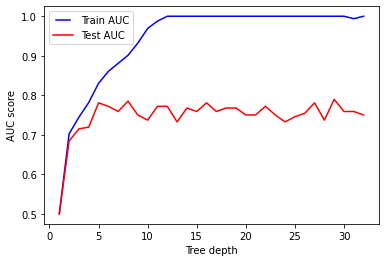

In [85]:
# Improve model to avoid overffiting: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf_model = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   rf_model.fit(X_train_scaled, y_train)

   train_pred = rf_model.predict(X_train_scaled)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)

   y_pred = rf_model.predict(X_test_scaled)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results,'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

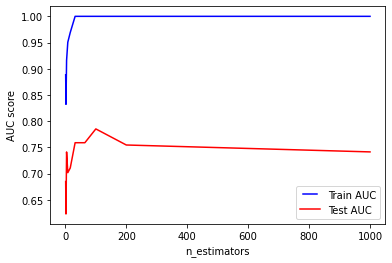

In [86]:
# n_estimators to avoid overfitting:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200, 1000]
train_results = []
test_results = []

for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)

   rf.fit(X_train_scaled, y_train)

   train_pred = rf.predict(X_train_scaled)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)

   y_pred = rf.predict(X_test_scaled)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

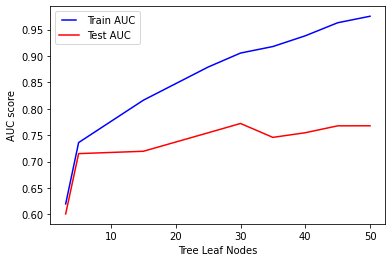

In [87]:
# Max Leaf Nodes, searching for overfitting:

max_leaf_nodes = [3, 5, 15, 25, 30, 35, 40, 45, 50]
train_results = []
test_results = []

for max_leaf in max_leaf_nodes:
   rf_model = RandomForestClassifier(max_leaf_nodes=max_leaf)
   rf_model.fit(X_train_scaled, y_train)

   train_pred = rf_model.predict(X_train_scaled)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)

   y_pred = rf_model.predict(X_test_scaled)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_leaf_nodes, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_leaf_nodes, test_results,'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree Leaf Nodes")
plt.show()

# **SMOTE**

Synthetic Minority Oversampling Technique
The synthetic minority oversampling technique (SMOTE) is another oversampling approach to deal with unbalanced datasets.

In [101]:
# 1. Define features set
X = db_companies_Encode_Model.copy()
X = X.drop(["more100_employees","soonicorn","more50_employees"], axis=1)
X.head()

,first_r_amount,rounds_funding_factor,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_amount,dp_years_operating,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer,foundation_year_2000,foundation_year_2004,foundation_year_2006,foundation_year_2008,foundation_year_2009,foundation_year_2010,foundation_year_2011,foundation_year_2012,foundation_year_2013,foundation_year_2014,foundation_year_2015,foundation_year_2016,foundation_year_2017,foundation_year_2018,foundation_year_2019,foundation_year_2020,foundation_year_2021,category_0,...,first_r_year_2012,first_r_year_2013,first_r_year_2014,first_r_year_2015,first_r_year_2016,first_r_year_2017,first_r_year_2018,first_r_year_2019,first_r_year_2020,first_r_year_2021,dp_year_0,dp_year_2000,dp_year_2008,dp_year_2011,dp_year_2012,dp_year_2013,dp_year_2014,dp_year_2015,dp_year_2016,dp_year_2017,dp_year_2018,dp_year_2019,dp_year_2020,dp_year_2021,current_status_0,current_status_1,dp_last_round_year_0,dp_last_round_year_2000,dp_last_round_year_2008,dp_last_round_year_2011,dp_last_round_year_2012,dp_last_round_year_2013,dp_last_round_year_2014,dp_last_round_year_2015,dp_last_round_year_2016,dp_last_round_year_2017,dp_last_round_year_2018,dp_last_round_year_2019,dp_last_round_year_2020,dp_last_round_year_2021
0,1400000,4,1,1400000,1400000,1400000,0,1,1,0,0,0,0,0,2,4,2,1,0,0,22,15,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,10500,3,1,10500,10500,10500,0,1,1,0,0,0,0,0,1,4,1,0,0,0,10,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,200000,6,1,200000,200000,200000,0,1,1,0,0,0,0,0,1,1,1,0,0,0,12,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,150000,0,5,54800000,40000000,40000000,8,0,1,0,0,0,0,0,1,2,1,0,0,0,11,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,20000,3,1,20000,20000,20000,0,0,1,1,0,0,0,0,0,1,1,1,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [102]:
# 2. Define the target set. 
# Here, we're using the ravel() method, which performs the same procedure on our target set data as the values attribute.
y = db_companies_Encode_Model["more50_employees"].ravel()
y[:5]

array([0, 0, 0, 1, 0])

In [103]:
# 3. Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78, test_size=0.30)

In [104]:
# 4. Creating StandardScaler instance
# Now that we have split our data into training and testing sets, we can scale the data using Scikit-learn's StandardScaler.

# Creating a StandardScaler instance.
scaler = StandardScaler()

# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

The following actions are taking place:

- The sampling_strategy argument specifies how the dataset is resampled. By default, it increases the minority class size to equal the majority class's size.
- Again, the fit_resample() method is used on the training data to train the SMOTE model and to oversample in a single step.
- Counting the number of instances by class verifies that they are now equal in size.

In [105]:
from imblearn.over_sampling import SMOTE
from collections import Counter
X_resampled, y_resampled = SMOTE(random_state=1,
sampling_strategy='auto').fit_resample(
   X_train_scaled, y_train)
Counter(y_resampled)

Counter({0: 276, 1: 276})

In [106]:
len(X_resampled)

552

In [94]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=10, random_state=42, max_leaf_nodes=20)

In [107]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(rf_model.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': 20, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [108]:
# Fitting the model
rf_model = rf_model.fit(X_resampled, y_resampled)

In [109]:
# Making predictions using the testing data
y_pred = rf_model.predict(X_test_scaled)

In [110]:
# Calculating the accuracy score.
acc_score = accuracy_score(y_test, y_pred)
acc_score

0.8300653594771242

In [111]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

cm_df

,Predicted 0,Predicted 1
Actual 0,98,17
Actual 1,9,29


In [112]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, y_pred))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,98,17
Actual 1,9,29


Accuracy Score : 0.8300653594771242
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       115
           1       0.63      0.76      0.69        38

    accuracy                           0.83       153
   macro avg       0.77      0.81      0.79       153
weighted avg       0.84      0.83      0.84       153



# **Balanced Random Forest Classifier**


In [113]:
# 1. Define features set
X = db_companies_Encode_Model.copy()
X = X.drop(["more100_employees","soonicorn","more50_employees"], axis=1)
X.head()

,first_r_amount,rounds_funding_factor,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_amount,dp_years_operating,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer,foundation_year_2000,foundation_year_2004,foundation_year_2006,foundation_year_2008,foundation_year_2009,foundation_year_2010,foundation_year_2011,foundation_year_2012,foundation_year_2013,foundation_year_2014,foundation_year_2015,foundation_year_2016,foundation_year_2017,foundation_year_2018,foundation_year_2019,foundation_year_2020,foundation_year_2021,category_0,...,first_r_year_2012,first_r_year_2013,first_r_year_2014,first_r_year_2015,first_r_year_2016,first_r_year_2017,first_r_year_2018,first_r_year_2019,first_r_year_2020,first_r_year_2021,dp_year_0,dp_year_2000,dp_year_2008,dp_year_2011,dp_year_2012,dp_year_2013,dp_year_2014,dp_year_2015,dp_year_2016,dp_year_2017,dp_year_2018,dp_year_2019,dp_year_2020,dp_year_2021,current_status_0,current_status_1,dp_last_round_year_0,dp_last_round_year_2000,dp_last_round_year_2008,dp_last_round_year_2011,dp_last_round_year_2012,dp_last_round_year_2013,dp_last_round_year_2014,dp_last_round_year_2015,dp_last_round_year_2016,dp_last_round_year_2017,dp_last_round_year_2018,dp_last_round_year_2019,dp_last_round_year_2020,dp_last_round_year_2021
0,1400000,4,1,1400000,1400000,1400000,0,1,1,0,0,0,0,0,2,4,2,1,0,0,22,15,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,10500,3,1,10500,10500,10500,0,1,1,0,0,0,0,0,1,4,1,0,0,0,10,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,200000,6,1,200000,200000,200000,0,1,1,0,0,0,0,0,1,1,1,0,0,0,12,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,150000,0,5,54800000,40000000,40000000,8,0,1,0,0,0,0,0,1,2,1,0,0,0,11,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,20000,3,1,20000,20000,20000,0,0,1,1,0,0,0,0,0,1,1,1,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [114]:
# 2. Define the target set. 
# Here, we're using the ravel() method, which performs the same procedure on our target set data as the values attribute.
y = db_companies_Encode_Model["more50_employees"].ravel()
y[:5]

array([0, 0, 0, 1, 0])

In [115]:
# 3. Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78, test_size=0.30)

In [116]:
# 4. Creating StandardScaler instance
# Now that we have split our data into training and testing sets, we can scale the data using Scikit-learn's StandardScaler.

# Creating a StandardScaler instance.
scaler = StandardScaler()

# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [117]:
# Resample the training data with the BalancedRandomForestClassifier
# Note: We use a random state of 42 for each algorithm to ensure consistency between tests
from imblearn.ensemble import BalancedRandomForestClassifier

rf = BalancedRandomForestClassifier(n_estimators=10, random_state=42, max_leaf_nodes=20)
rf.fit(X_train_scaled, y_train)  

BalancedRandomForestClassifier(max_leaf_nodes=20, n_estimators=10,
                               random_state=42)

In [118]:
# Calculated the balanced accuracy score}
from sklearn.metrics import balanced_accuracy_score
y_pred = rf.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.7993135011441648

In [119]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[87, 28],
       [ 6, 32]])

In [120]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.76      0.84      0.84      0.80      0.63       115
          1       0.53      0.84      0.76      0.65      0.80      0.64        38

avg / total       0.84      0.78      0.82      0.79      0.80      0.63       153



In [121]:
# List the features sorted in descending order by feature importance
sorted(zip(rf.feature_importances_, X.columns), reverse=True)

[(0.18936840164134644, 'dp_rounds_amount_sum'),
 (0.1425534545002023, 'dp_rounds_amount_max'),
 (0.08973940794005927, 'dp_last_round_amount'),
 (0.06670169946153467, 'first_r_amount'),
 (0.053597827189734736, 'dp_rounds_count'),
 (0.033527654632667755, 'sum_dp_years_of_experience_as_entreprenuer'),
 (0.02726312317749936, 'sum_clevel_exp'),
 (0.02538350810774685, 'sum_dp_years_of_experience'),
 (0.024094867633899973, 'rounds_funding_factor'),
 (0.023823102356681454, 'sum_foreing_studies'),
 (0.022972799815856707, 'sum_manager_exp'),
 (0.022349098941767655, 'dp_years_operating'),
 (0.019975041061534835, 'sum_foreing_founder'),
 (0.01764641804096482, 'foundation_year_2021'),
 (0.017277460634415612, 'sum_founder_exp'),
 (0.013455317152188043, 'sum_engineering_exp'),
 (0.012843100727767554, 'dp_last_round_year_2016'),
 (0.012726387677211237, 'dp_year_2017'),
 (0.01228337733198909, 'dp_year_2016'),
 (0.01133962817437511, 'foundation_year_2018'),
 (0.010319134756023921, 'foundation_year_2020'

In [122]:
# ROC Curve indicator: The ROC curve stands for Receiver Operating Characteristic curve, and is used to visualize the performance of a classifier. 
# References: https://datamize.wordpress.com/2015/01/24/how-to-plot-a-roc-curve-in-scikit-learn/
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)

0.7993135011441647


Text(0.5, 0, 'False Positive Rate')

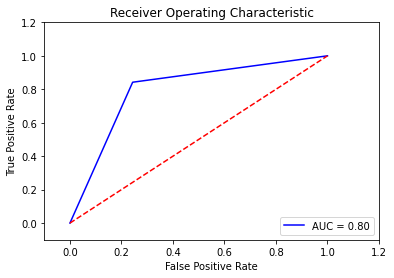

In [123]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

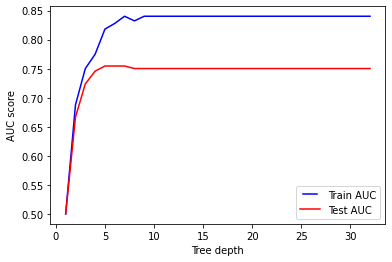

In [125]:
# Improve model to avoid overffiting: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf_model = RandomForestClassifier(max_depth=max_depth, random_state=42, max_leaf_nodes=20, n_jobs=-1)
   rf_model.fit(X_train_scaled, y_train)

   train_pred = rf_model.predict(X_train_scaled)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)

   y_pred = rf_model.predict(X_test_scaled)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results,'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

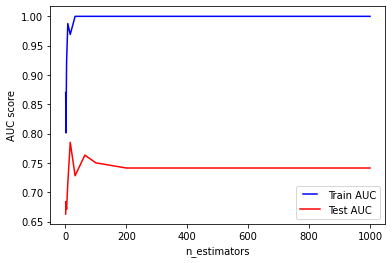

In [126]:
# n_estimators to avoid overfitting:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200, 1000]
train_results = []
test_results = []

for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)

   rf.fit(X_train_scaled, y_train)

   train_pred = rf.predict(X_train_scaled)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)

   y_pred = rf.predict(X_test_scaled)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

# **Undersampling**

In [127]:
# 1. Define features set
X = db_companies_Encode_Model.copy()
X = X.drop(["more100_employees","soonicorn","more50_employees"], axis=1)
X.head()

,first_r_amount,rounds_funding_factor,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_amount,dp_years_operating,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer,foundation_year_2000,foundation_year_2004,foundation_year_2006,foundation_year_2008,foundation_year_2009,foundation_year_2010,foundation_year_2011,foundation_year_2012,foundation_year_2013,foundation_year_2014,foundation_year_2015,foundation_year_2016,foundation_year_2017,foundation_year_2018,foundation_year_2019,foundation_year_2020,foundation_year_2021,category_0,...,first_r_year_2012,first_r_year_2013,first_r_year_2014,first_r_year_2015,first_r_year_2016,first_r_year_2017,first_r_year_2018,first_r_year_2019,first_r_year_2020,first_r_year_2021,dp_year_0,dp_year_2000,dp_year_2008,dp_year_2011,dp_year_2012,dp_year_2013,dp_year_2014,dp_year_2015,dp_year_2016,dp_year_2017,dp_year_2018,dp_year_2019,dp_year_2020,dp_year_2021,current_status_0,current_status_1,dp_last_round_year_0,dp_last_round_year_2000,dp_last_round_year_2008,dp_last_round_year_2011,dp_last_round_year_2012,dp_last_round_year_2013,dp_last_round_year_2014,dp_last_round_year_2015,dp_last_round_year_2016,dp_last_round_year_2017,dp_last_round_year_2018,dp_last_round_year_2019,dp_last_round_year_2020,dp_last_round_year_2021
0,1400000,4,1,1400000,1400000,1400000,0,1,1,0,0,0,0,0,2,4,2,1,0,0,22,15,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,10500,3,1,10500,10500,10500,0,1,1,0,0,0,0,0,1,4,1,0,0,0,10,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,200000,6,1,200000,200000,200000,0,1,1,0,0,0,0,0,1,1,1,0,0,0,12,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,150000,0,5,54800000,40000000,40000000,8,0,1,0,0,0,0,0,1,2,1,0,0,0,11,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,20000,3,1,20000,20000,20000,0,0,1,1,0,0,0,0,0,1,1,1,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [128]:
# 2. Define the target set. 
# Here, we're using the ravel() method, which performs the same procedure on our target set data as the values attribute.
y = db_companies_Encode_Model["more50_employees"].ravel()
y[:5]

array([0, 0, 0, 1, 0])

In [129]:
# 3. Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78, test_size=0.30)

In [130]:
# 4. Creating StandardScaler instance
# Now that we have split our data into training and testing sets, we can scale the data using Scikit-learn's StandardScaler.

# Creating a StandardScaler instance.
scaler = StandardScaler()

# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [131]:
# Undersample the data using `RandomUnderSampler`
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
ros = RandomUnderSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({0: 81, 1: 81})

In [132]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=10, random_state=42, max_leaf_nodes=20)

In [133]:
# Fitting the model
rf_model = rf_model.fit(X_resampled, y_resampled)

In [134]:
# Making predictions using the testing data
y_pred = rf_model.predict(X_test_scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [135]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

cm_df

,Predicted 0,Predicted 1
Actual 0,108,7
Actual 1,34,4


In [136]:
# Calculating the accuracy score.
acc_score = accuracy_score(y_test, y_pred)
acc_score

0.7320261437908496

In [137]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, y_pred))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,108,7
Actual 1,34,4


Accuracy Score : 0.7320261437908496
Classification Report
              precision    recall  f1-score   support

           0       0.76      0.94      0.84       115
           1       0.36      0.11      0.16        38

    accuracy                           0.73       153
   macro avg       0.56      0.52      0.50       153
weighted avg       0.66      0.73      0.67       153



In [138]:
# Calculate the Balanced Accuracy Score
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)

0.5221967963386728

In [139]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.76      0.94      0.11      0.84      0.31      0.11       115
          1       0.36      0.11      0.94      0.16      0.31      0.09        38

avg / total       0.66      0.73      0.31      0.67      0.31      0.10       153



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with

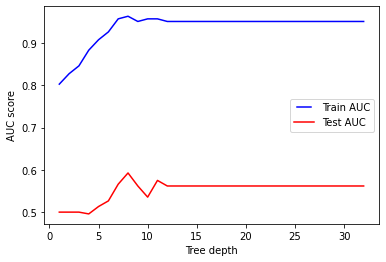

In [141]:
# Improve model to avoid overfiting: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf_model = RandomForestClassifier(max_depth=max_depth, random_state=42, max_leaf_nodes=20, n_jobs=-1)
   rf_model.fit(X_resampled, y_resampled)

   train_pred = rf_model.predict(X_resampled)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_resampled, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)

   y_pred = rf_model.predict(X_test_scaled)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results,'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with

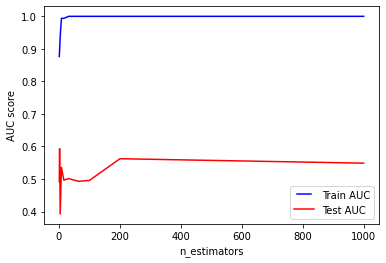

In [143]:
# n_estimators to avoid overfitting:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200, 1000]
train_results = []
test_results = []

for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)

   rf.fit(X_resampled, y_resampled)

   train_pred = rf.predict(X_resampled)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_resampled, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)

   y_pred = rf.predict(X_test_scaled)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()